In [ ]:
# LSTM에 순환층과 순환드롭아웃을 적용한다
# dropout 적용하니 성능이 더 안좋아짐

In [1]:
conda install tensorflow

Retrieving notices: ...working... done
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [4]:
data = pd.read_csv('../data/cpu_memory_usage_20230409.csv', header=0)
data['time'] = pd.to_datetime(data['time'], unit='ns')
data = data.loc[data.namespace == 'drive']
date_time = pd.to_datetime(data['time'], format='%Y-%M-%D %H:%M:%S')
data

,name,tags,time,pod_name,namespace,mean_cpu_usage_nanocores,mean_memory_working_set_bytes
96,kubernetes_pod_container,NaN,2023-04-07 16:00:00,drive-az2-prd-85645f87d9-mpw5q,drive,1.773410e+07,1.334707e+09
100,kubernetes_pod_container,NaN,2023-04-07 16:00:00,drive-az2-prd-85645f87d9-s2kw8,drive,1.748167e+07,1.310027e+09
103,kubernetes_pod_container,NaN,2023-04-07 16:00:00,drive-az2-prd-85645f87d9-888jq,drive,1.104169e+07,1.272855e+09
109,kubernetes_pod_container,NaN,2023-04-07 16:00:00,drive-az2-prd-85645f87d9-bn97q,drive,1.801984e+07,1.403893e+09
112,kubernetes_pod_container,NaN,2023-04-07 16:00:00,drive-az2-prd-85645f87d9-rw5qk,drive,1.457886e+07,1.401893e+09
...,...,...,...,...,...,...,...
781535,kubernetes_pod_container,NaN,2023-03-03 00:00:00,drive-az2-prd-69cbb999bc-r6wq2,drive,1.082766e+08,1.202945e+09
781651,kubernetes_pod_container,NaN,2023-03-03 00:00:00,drive-az2-prd-69cbb999bc-g5dpb,drive,6.636116e+07,1.283052e+09
781664,kubernetes_pod_container,NaN,2023-03-03 00:00:00,drive-az2-prd-69cbb999bc-gw9xt,drive,1.145962e+08,1.308961e+09
781815,kubernetes_pod_container,NaN,2023-03-03 00:00:00,drive-az2-prd-69cbb999bc-wklkm,drive,1.155693e+08,1.225552e+09


In [5]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [6]:
data = data.loc[:,['mean_memory_working_set_bytes']]

In [7]:
seq_length = 24
X, Y = create_sequences(data, seq_length)
X.shape, Y.shape
X[0] #1.27417204e+09

array([[1.33470669e+09],
       [1.31002727e+09],
       [1.27285472e+09],
       [1.40389339e+09],
       [1.40189259e+09],
       [1.30463358e+09],
       [1.44382369e+09],
       [1.39535762e+09],
       [1.41588972e+09],
       [1.41645871e+09],
       [1.33890314e+09],
       [1.29920075e+09],
       [1.25934739e+09],
       [1.41135913e+09],
       [1.41291325e+09],
       [1.33008821e+09],
       [1.45881798e+09],
       [1.42025639e+09],
       [1.41348826e+09],
       [1.40255522e+09],
       [1.43363301e+09],
       [1.35977192e+09],
       [1.31844335e+09],
       [1.42308837e+09]])

In [8]:
train_size = 8000
offset_size = 500
X_train, y_train = X[:train_size], Y[:train_size]
X_val, y_val = X[train_size:train_size+offset_size], Y[train_size:train_size+offset_size]
X_test, y_test = X[train_size+offset_size:], Y[train_size+offset_size:]

In [9]:

MIN = X_train.min()
MAX = X_train.max()

In [10]:

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

In [11]:

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

In [12]:
y_train = pd.DataFrame(y_train, columns = ['mean_memory_working_set_bytes'])
y_val = pd.DataFrame(y_val, columns = ['mean_memory_working_set_bytes'])

y_test = pd.DataFrame(y_test, columns = ['mean_memory_working_set_bytes'])
y_test

,mean_memory_working_set_bytes
0,0.184795
1,0.131135
2,0.319655
3,0.215983
4,0.222026
...,...
1024,0.163620
1025,0.237155
1026,0.260938
1027,0.184372


In [13]:

X_train_tensors_f = tf.reshape(X_train,   (X_train.shape[0], 1, X_train.shape[1]))
X_test_tensors_f = tf.reshape(X_test,  (X_test.shape[0], 1, X_test.shape[1])) 

print("Training Shape", X_train_tensors_f.shape, y_train.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test.shape) 

Training Shape (8000, 1, 24) (8000, 1)
Testing Shape (1029, 1, 24) (1029, 1)


In [62]:
X_train_tensors_f.shape[-2:]

TensorShape([1, 24])

In [71]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train_tensors_f.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [72]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint

MAX_EPOCHS = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=2,
                                                mode='min')

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
history = lstm_model.fit(X_train_tensors_f, y_train, epochs=MAX_EPOCHS,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/20
243/250 [============================>.] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0668
Epoch 1: loss improved from inf to 0.00851, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 3s 3ms/step - loss: 0.0085 - mean_absolute_error: 0.0666
Epoch 2/20
237/250 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0582
Epoch 2: loss improved from 0.00851 to 0.00621, saving model to model/tmp_checkpoint_v3.h5
250/250 [==============================] - 1s 3ms/step - loss: 0.0062 - mean_absolute_error: 0.0580
Epoch 3/20
235/250 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0585
Epoch 3: loss did not improve from 0.00621
250/250 [==============================] - 1s 3ms/step - loss: 0.0062 - mean_absolute_error: 0.0582
Epoch 4/20
238/250 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0576
Epoch 4: loss improved from 0.00621 to 0.00619, sav

In [73]:
performance = {}
performance['lstm_model'] = lstm_model.evaluate(X_test_tensors_f, y_test, verbose=0)

In [74]:
train_predict = lstm_model.predict(X_test_tensors_f)

33/33 [==============================] - 1s 1ms/step


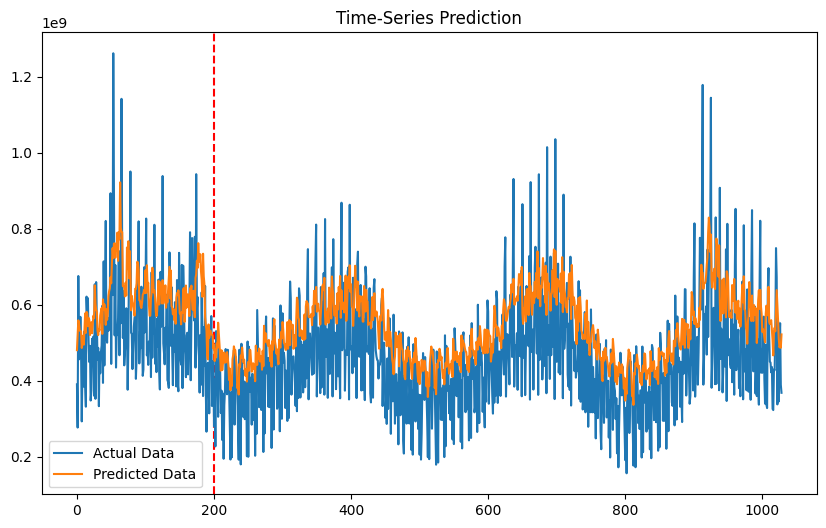

In [75]:

predicted= train_predict * MAX
label_y = y_test * MAX
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted[:,0,:], label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [76]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

lstm_model  : 0.0558
